In [1]:
#!pip install torchxrayvision

import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import tqdm
import sklearn, sklearn.metrics
import pandas as pd
import torchxrayvision as xrv
import skimage

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# NIH Data
# !mkdir capstone
# !cp /content/gdrive/MyDrive/Capstone/images_001.tar.gz /content/capstone/images

# !tar -xf /content/gdrive/MyDrive/capstone/images-224.tar -C /content/capstone

cp: cannot stat '/content/gdrive/MyDrive/Capstone/images_001.tar.gz': No such file or directory


In [ ]:
# %%time
# !cp /content/gdrive/MyDrive/capstone/CheXpert-v1.0-small.zip /content/
# !mkdir CheXpert
# !unzip -q CheXpert-v1.0-small.zip -d /content/CheXpert/

CPU times: user 2.41 s, sys: 341 ms, total: 2.75 s
Wall time: 5min 35s


In [ ]:
# !ls /content/CheXpert/CheXpert-v1.0-small/train/patient12852/study1/view1_frontal.jpg
# !ls /content/CheXpert/CheXpert-v1.0-small/train/patient49183/study2/view1_frontal.jpg


/content/CheXpert/CheXpert-v1.0-small/train/patient49183/study2/view1_frontal.jpg


Shape: (320, 390)


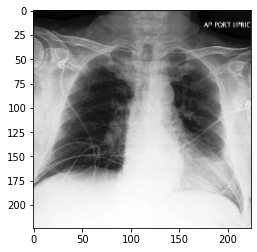

In [12]:
colab = False
dataset_path = "/content/CheXpert/" if colab else "."
img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg"
chexpert_img = skimage.io.imread(img_path)

print(f"Shape: {chexpert_img.shape}")
plt.imshow(chexpert_img, cmap="Greys_r")
plt_img_before = np.copy(chexpert_img)

def normalize_img(img):
    chexpert_img = xrv.datasets.normalize(img, 255)
    chexpert_img = chexpert_img[None, :, :]
    transform = torchvision.transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(224),
    ])
    chexpert_img = transform(chexpert_img)
    chexpert_img = torch.from_numpy(chexpert_img).unsqueeze(0)
    return chexpert_img

chexpert_img = normalize_img(chexpert_img)
plt.imshow(chexpert_img[0, 0], cmap="Greys_r")

(1, 1, 224, 224)


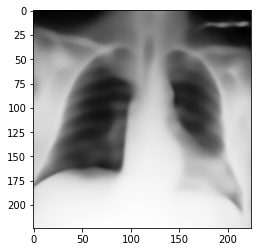

In [4]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic")
#out = ae(chexpert_img)
z = ae.encode(chexpert_img)
decoded = ae.decode(z).detach().numpy()
#img_r = out['out'].detach().numpy()
print(decoded.shape)
plt.imshow(decoded[0][0], cmap="Greys_r")

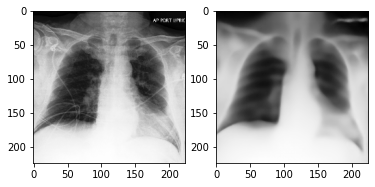

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(chexpert_img[0, 0], cmap='Greys_r')
ax[1].imshow(decoded[0][0], cmap='Greys_r')

   0 Loss: 6027.3340 | Loss reconstruction: 6027.3340
   1 Loss: 5737.8984 | Loss reconstruction: 5737.8984
   2 Loss: 5636.8799 | Loss reconstruction: 5636.8799
   3 Loss: 5580.5356 | Loss reconstruction: 5580.5356
   4 Loss: 5537.7412 | Loss reconstruction: 5537.7412
   5 Loss: 5507.9243 | Loss reconstruction: 5507.9243
   6 Loss: 5483.4604 | Loss reconstruction: 5483.4604
   7 Loss: 5457.8057 | Loss reconstruction: 5457.8057
   8 Loss: 5434.0742 | Loss reconstruction: 5434.0742
   9 Loss: 5413.7764 | Loss reconstruction: 5413.7764
  10 Loss: 5396.6440 | Loss reconstruction: 5396.6440
  11 Loss: 5382.3174 | Loss reconstruction: 5382.3174
  12 Loss: 5370.6084 | Loss reconstruction: 5370.6084
  13 Loss: 5361.6694 | Loss reconstruction: 5361.6694
  14 Loss: 5355.4043 | Loss reconstruction: 5355.4043
  15 Loss: 5350.2183 | Loss reconstruction: 5350.2183
  16 Loss: 5344.3340 | Loss reconstruction: 5344.3340
  17 Loss: 5338.0498 | Loss reconstruction: 5338.0498
  18 Loss: 5331.2573 | Loss 

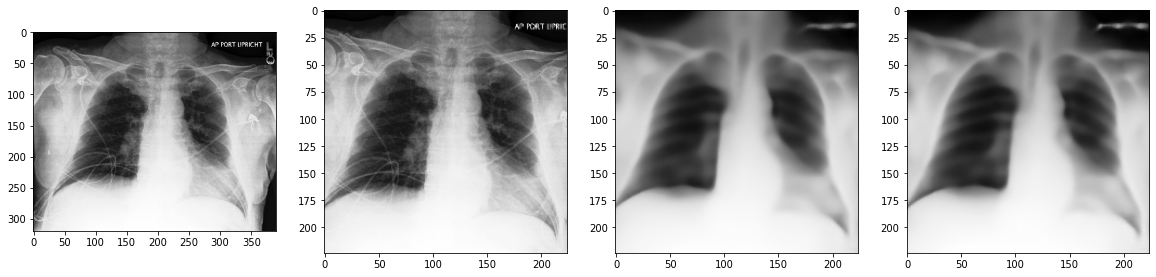

In [27]:
def find_counterfactual(input_img):
    input_img = normalize_img(input_img)
    z_init = ae.encode(input_img)
    # optimize z
    z = z_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([z], lr=0.03)
    for i in range(30):
        optimizer.zero_grad()
        img_r = ae.decode(z)
        loss_reconstruction = F.mse_loss(img_r, input_img)
        
        loss = loss_reconstruction
        print(f"{i:4} Loss: {loss.item():.4f} | Loss reconstruction: {loss_reconstruction.item():.4f}")
        loss.backward()
        optimizer.step()

    # output image
    img_r_init = ae.decode(z_init).detach().numpy()
    img_r = ae.decode(z).detach().numpy()
    return input_img, img_r_init, img_r


img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg"
input_img = skimage.io.imread(img_path)

img_norm, img_r_init, img_r = find_counterfactual(input_img)
fig, ax = plt.subplots(1,4, figsize=(20,10))
ax[0].imshow(input_img, cmap='Greys_r')
ax[1].imshow(img_norm[0][0], cmap='Greys_r')
ax[2].imshow(img_r_init[0][0], cmap='Greys_r');
ax[3].imshow(img_r[0][0], cmap='Greys_r');